# ScanPy Analysis

We will do a naive analysis, using the filters we discovered in the previous notebook. Namely:

 * Mitochondrial genes out
 * Ribosomal protein coding genes out
 * FTH1 out

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'

scanpy==1.4.1 anndata==0.6.19 numpy==1.16.3 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
sc.settings.set_figure_params(dpi=80)

In [14]:
ad_ctr = sc.read_10x_mtx(
    './sources/ctr',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)

ad_ctr.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
ad_ctr

... reading from cache file cache/sources-ctr-matrix.h5ad


AnnData object with n_obs × n_vars = 3709 × 33694 
    var: 'gene_ids'

In [13]:
ad_sin = sc.read_10x_mtx(
    './sources/siN6amt1',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)

ad_sin.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
ad_sin

... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 4515 × 33694 
    var: 'gene_ids'

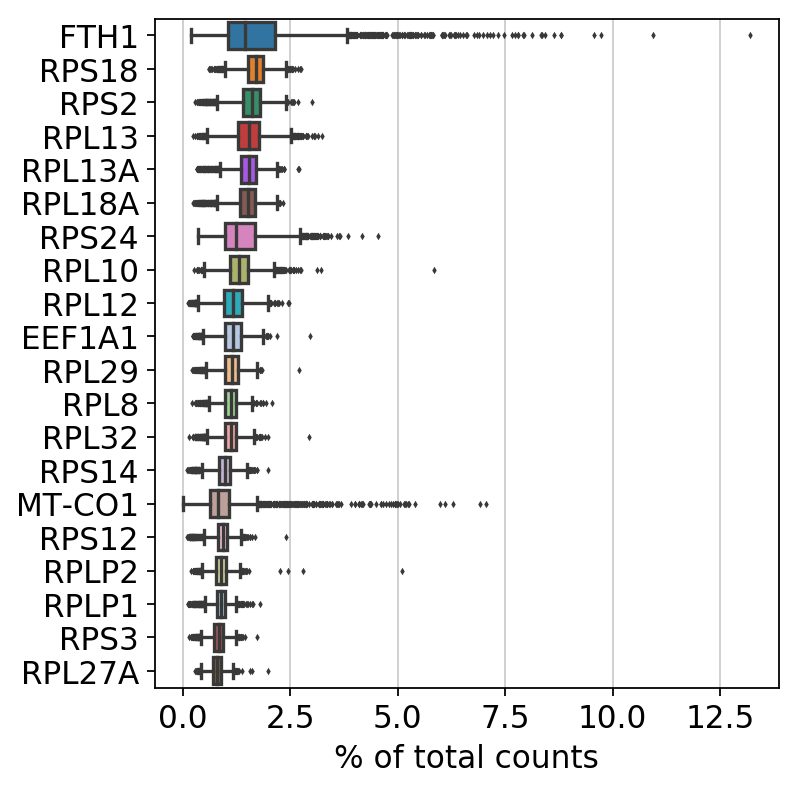

In [15]:
sc.pl.highest_expr_genes(ad_ctr, n_top=20)

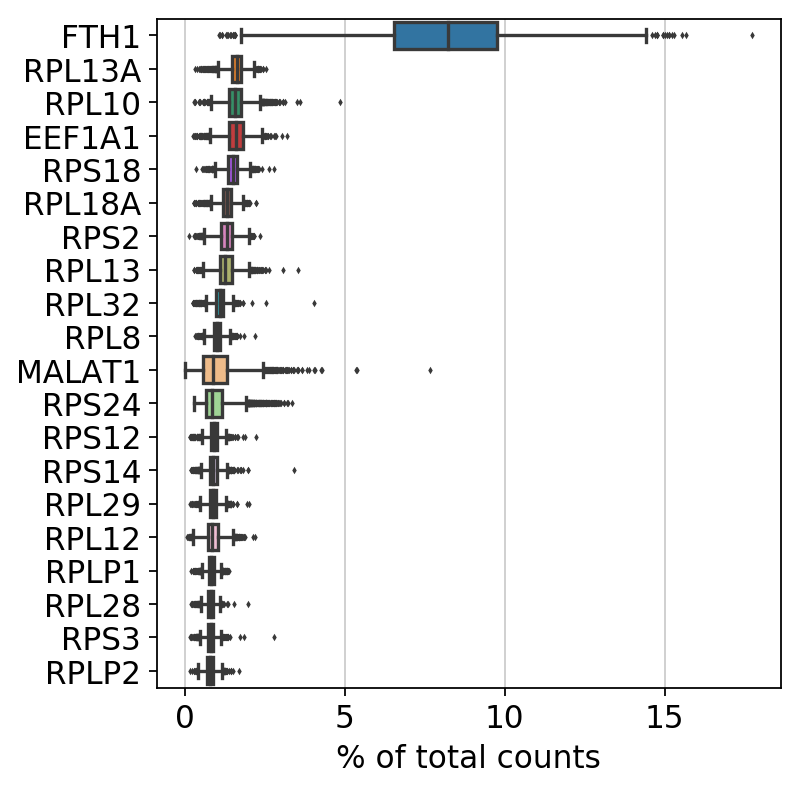

In [16]:
sc.pl.highest_expr_genes(ad_sin, n_top=20)

In [17]:
sc.pp.filter_cells(ad_ctr, min_genes=200)
sc.pp.filter_genes(ad_ctr, min_cells=3)
sc.pp.filter_cells(ad_sin, min_genes=200)
sc.pp.filter_genes(ad_sin, min_cells=3)

filtered out 15054 genes that are detected in less than 3 cells
filtered out 15634 genes that are detected in less than 3 cells


## The Mitochondrial Factor

In [19]:
def calcMito(obj):
    mito_genes = obj.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    obj.obs['percent_mito'] = np.sum(obj[:, mito_genes].X, axis=1).A1 / np.sum(obj.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    obj.obs['n_counts'] = obj.X.sum(axis=1).A1

In [20]:
calcMito(ad_ctr)
calcMito(ad_sin)

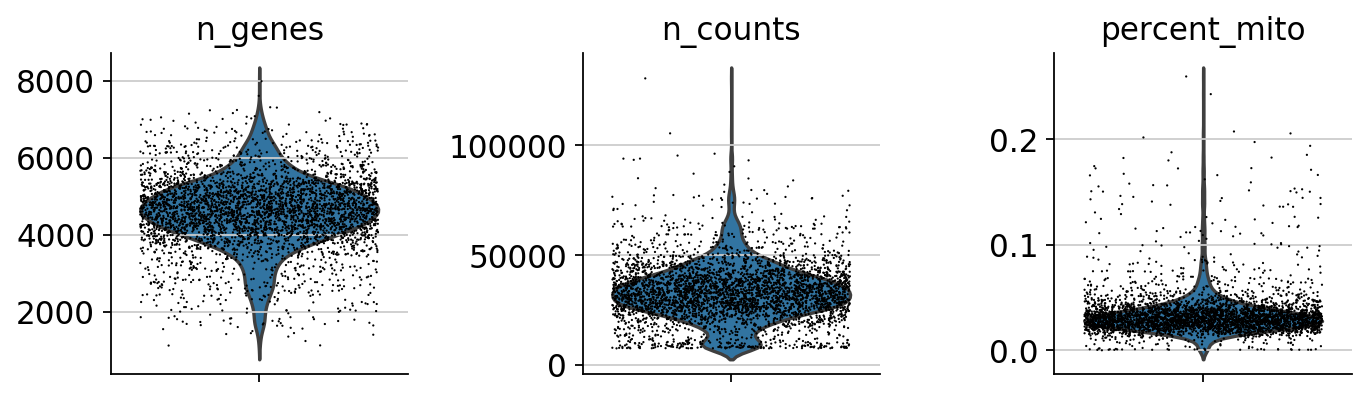

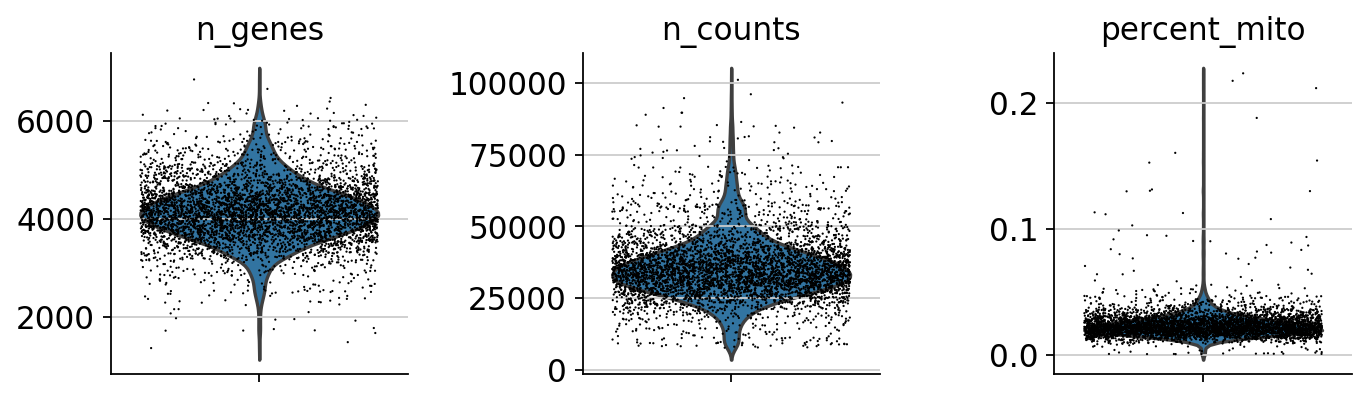

In [21]:
sc.pl.violin(ad_ctr, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
sc.pl.violin(ad_sin, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)


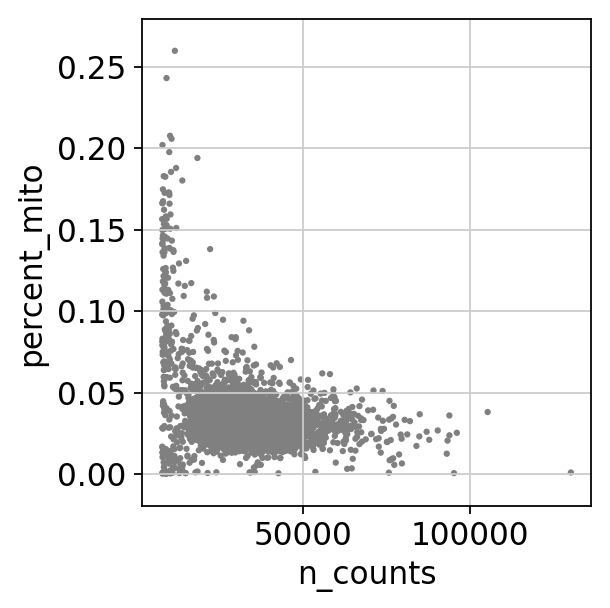

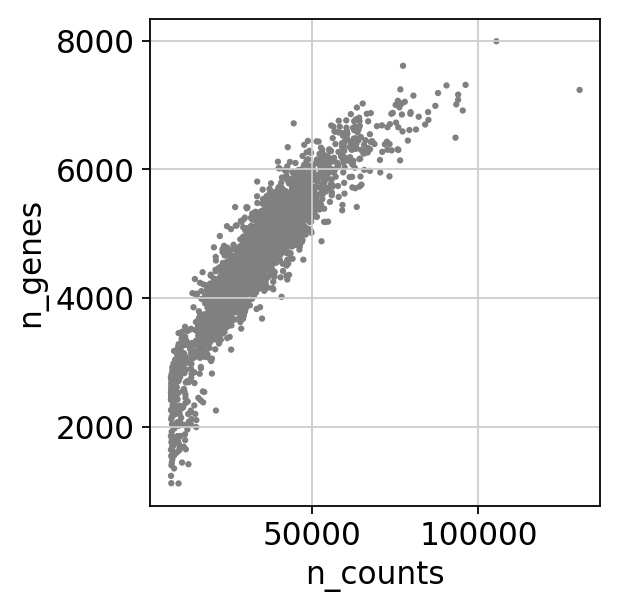

In [25]:
sc.pl.scatter(ad_ctr, x='n_counts', y='percent_mito')
sc.pl.scatter(ad_ctr, x='n_counts', y='n_genes')

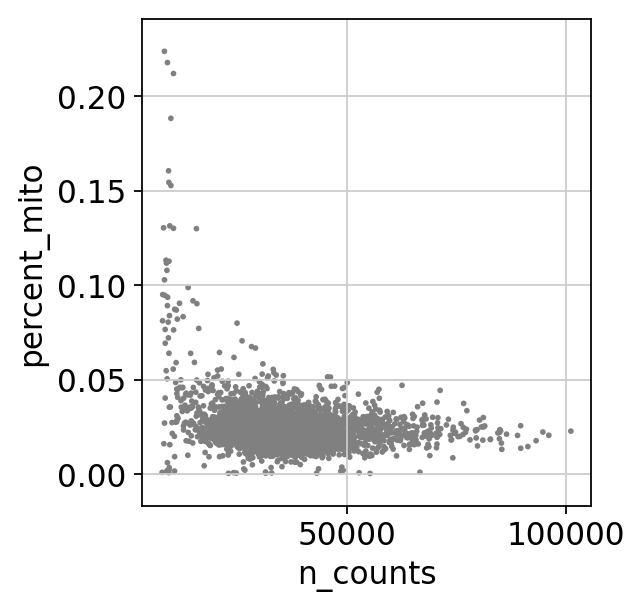

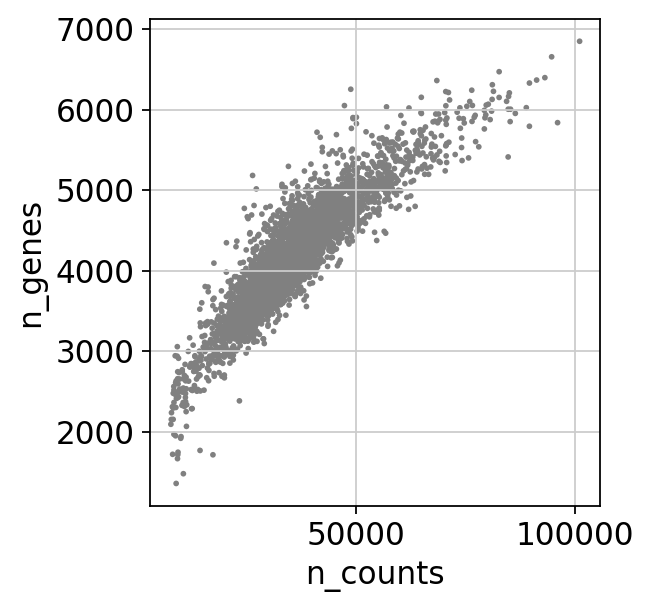

In [26]:
sc.pl.scatter(ad_sin, x='n_counts', y='percent_mito')
sc.pl.scatter(ad_sin, x='n_counts', y='n_genes')

Filtering of 0.05 for MT% in both, and 6000 for upper limit of #features for sin and 7000 in ctr. 

In [27]:
ad_ctr = ad_ctr[ad_ctr.obs['n_genes'] < 7000, :]
ad_ctr = ad_ctr[ad_ctr.obs['percent_mito'] < 0.05, :]

ad_sin = ad_sin[ad_sin.obs['n_genes'] < 6000, :]
ad_sin = ad_sin[ad_sin.obs['percent_mito'] < 0.05, :]

In [28]:
# Libsize normalisation, large set -- doing this is fine
sc.pp.normalize_per_cell(ad_ctr, counts_per_cell_after=1e4)
sc.pp.normalize_per_cell(ad_sin, counts_per_cell_after=1e4)

In [29]:
# Log data
sc.pp.log1p(ad_ctr)
sc.pp.log1p(ad_sin)

In [30]:
# Overwrite the raw data with the log counts, so that these are what get used during DE visualatising.
ad_ctr.raw = ad_ctr
ad_sin.raw = ad_sin

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


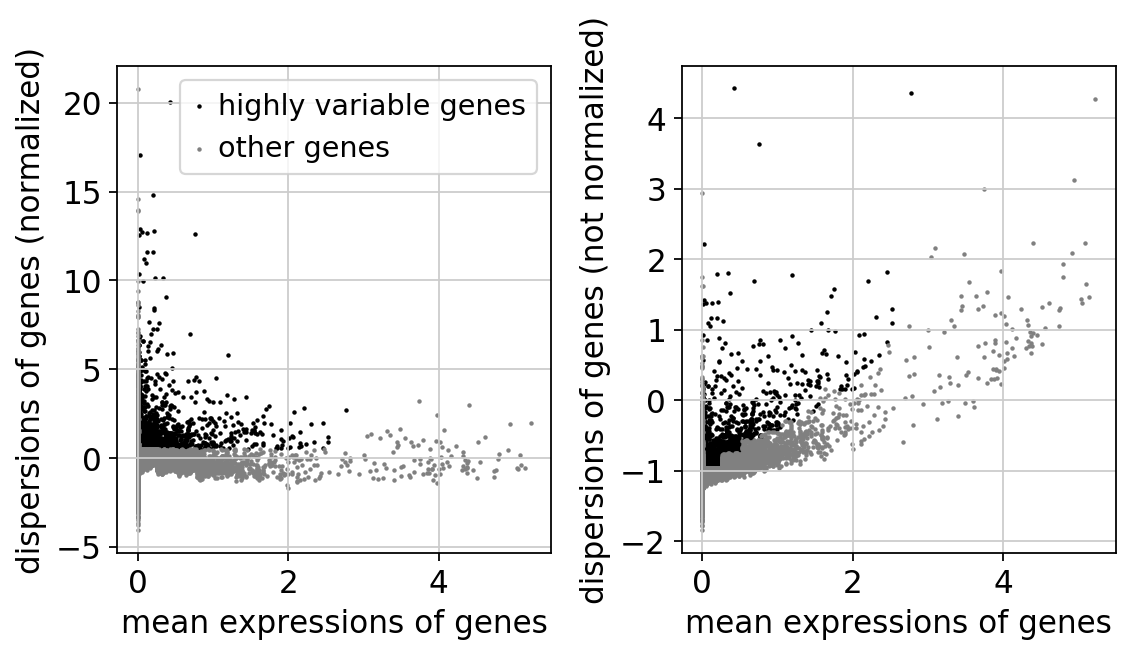

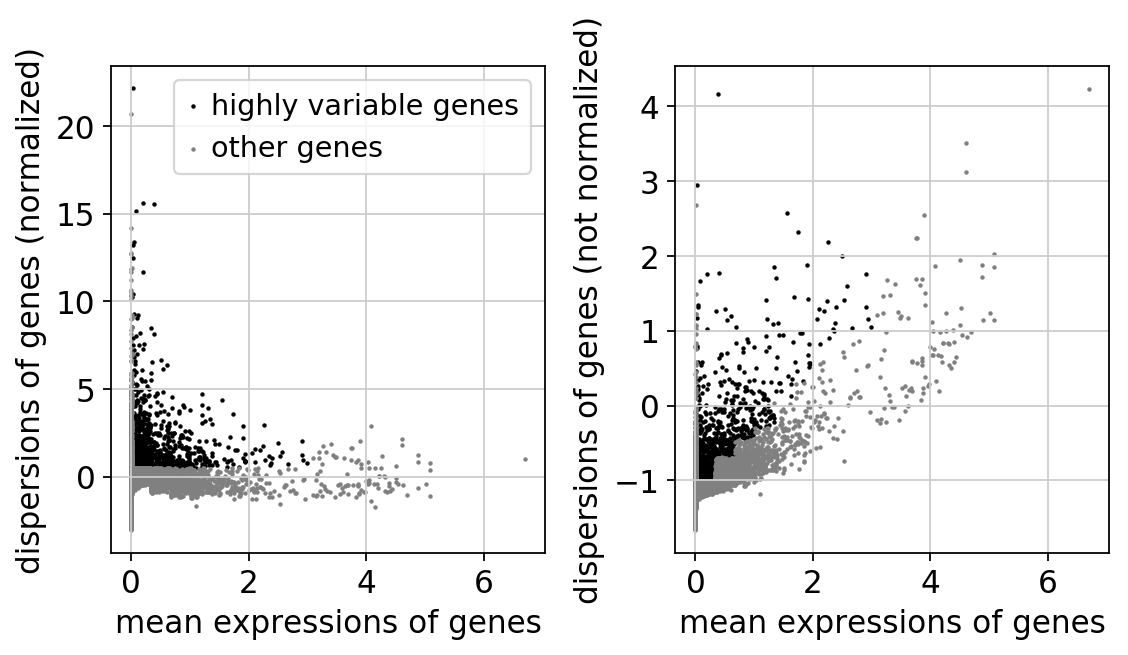

In [31]:
sc.pp.highly_variable_genes(ad_ctr, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(ad_sin, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(ad_ctr)
sc.pl.highly_variable_genes(ad_sin)

In [32]:
# Filter for the genes (the black cells)
ad_ctr = ad_ctr[:, ad_ctr.var['highly_variable']]
ad_sin = ad_sin[:, ad_sin.var['highly_variable']]

In [33]:
# Regress out effects of total counts per cell and % of MT genes expressed. Scale the data to unit variance.
sc.pp.regress_out(ad_ctr, ['n_counts', 'percent_mito'])
sc.pp.regress_out(ad_sin, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:09.99)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:11.02)


In [34]:
sc.pp.scale(ad_ctr, max_value=10)
sc.pp.scale(ad_sin, max_value=10)

## Principle Component Analysis

Reduce the dimensionality of the data using PCA.

In [35]:
sc.tl.pca(ad_ctr, svd_solver='arpack')
sc.tl.pca(ad_sin, svd_solver='arpack')

computing PCA on highly variable genes
computing PCA on highly variable genes


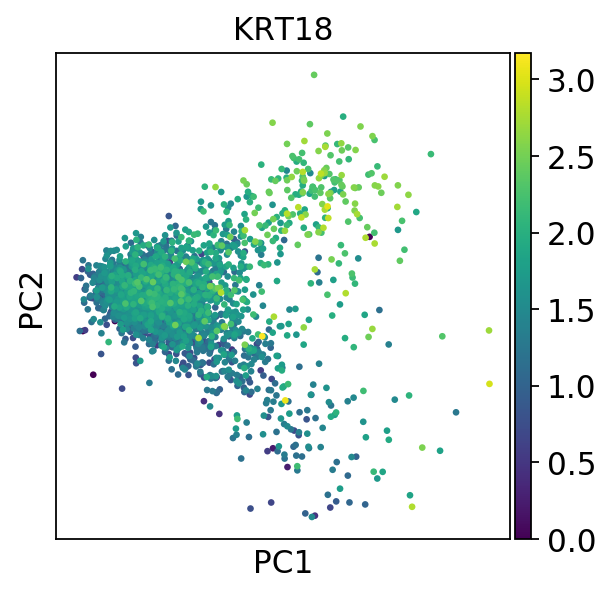

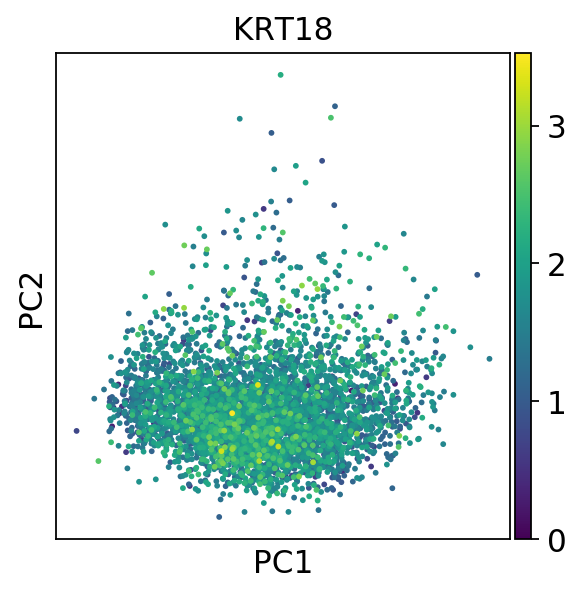

In [47]:
sc.pl.pca(ad_ctr, color='KRT18')
sc.pl.pca(ad_sin, color='KRT18')

#sc.pl.pca(ad_ctr, color='')
#sc.pl.pca(ad_sin, color='FTH1')

The SIN matrix doesn't seem to seperate well for the first two components. Let's see how many PCs we need to include.

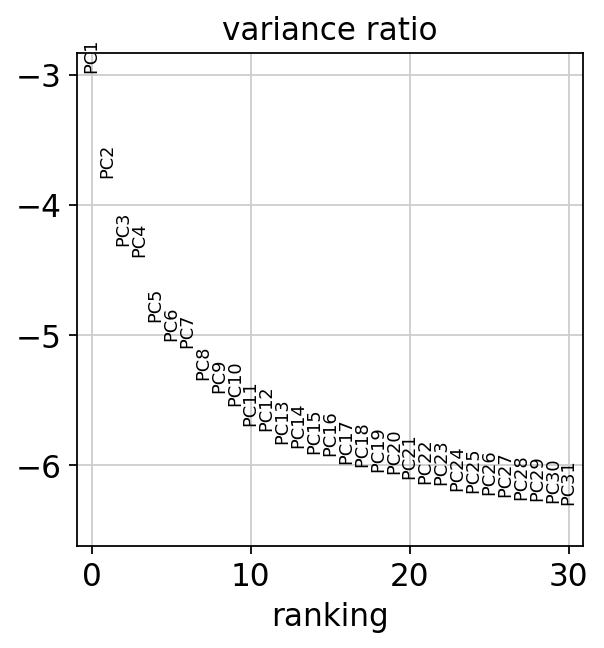

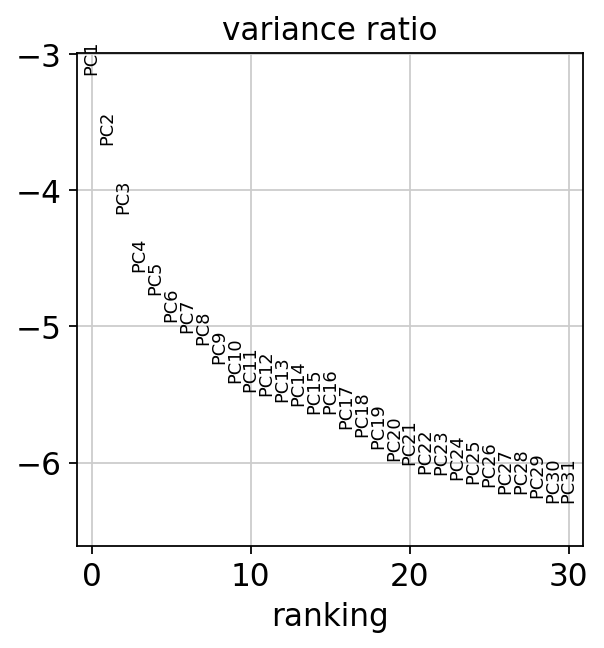

In [37]:
sc.pl.pca_variance_ratio(ad_ctr, log=True)
sc.pl.pca_variance_ratio(ad_sin, log=True)

In [39]:
# Can use these for ucsc cell browser
ad_ctr.write("checkpoints/scanpy.ctr.h5ad")
ad_sin.write("checkpoints/scanpy.sin.h5ad")

# Compute a neighbourhood graph

Here we abstract clusters using a neighbourhood graph.

In [41]:
sc.pp.neighbors(ad_ctr, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(ad_sin, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:04.03) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.78) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [43]:
# Only run this if connectivity is weak
#sc.tl.paga(ad_ctr)
#sc.pl.paga(ad_ctr, plot=True)
#sc.tl.umap(ad_ctr, init_pos='paga')

In [44]:
sc.tl.umap(ad_ctr)
sc.tl.umap(ad_sin)

computing UMAP
    finished (0:00:05.96) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing UMAP
    finished (0:00:06.16) --> added
    'X_umap', UMAP coordinates (adata.obsm)


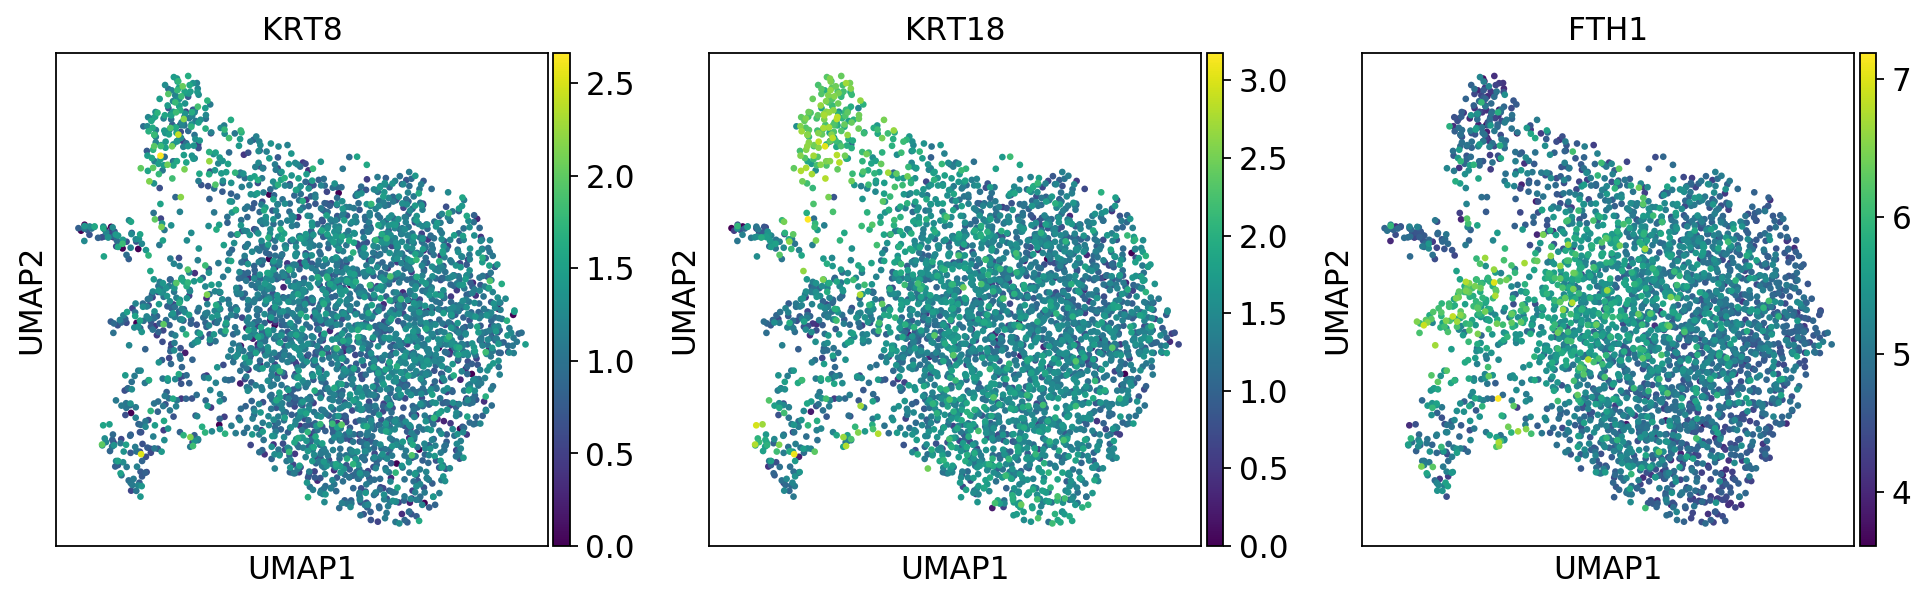

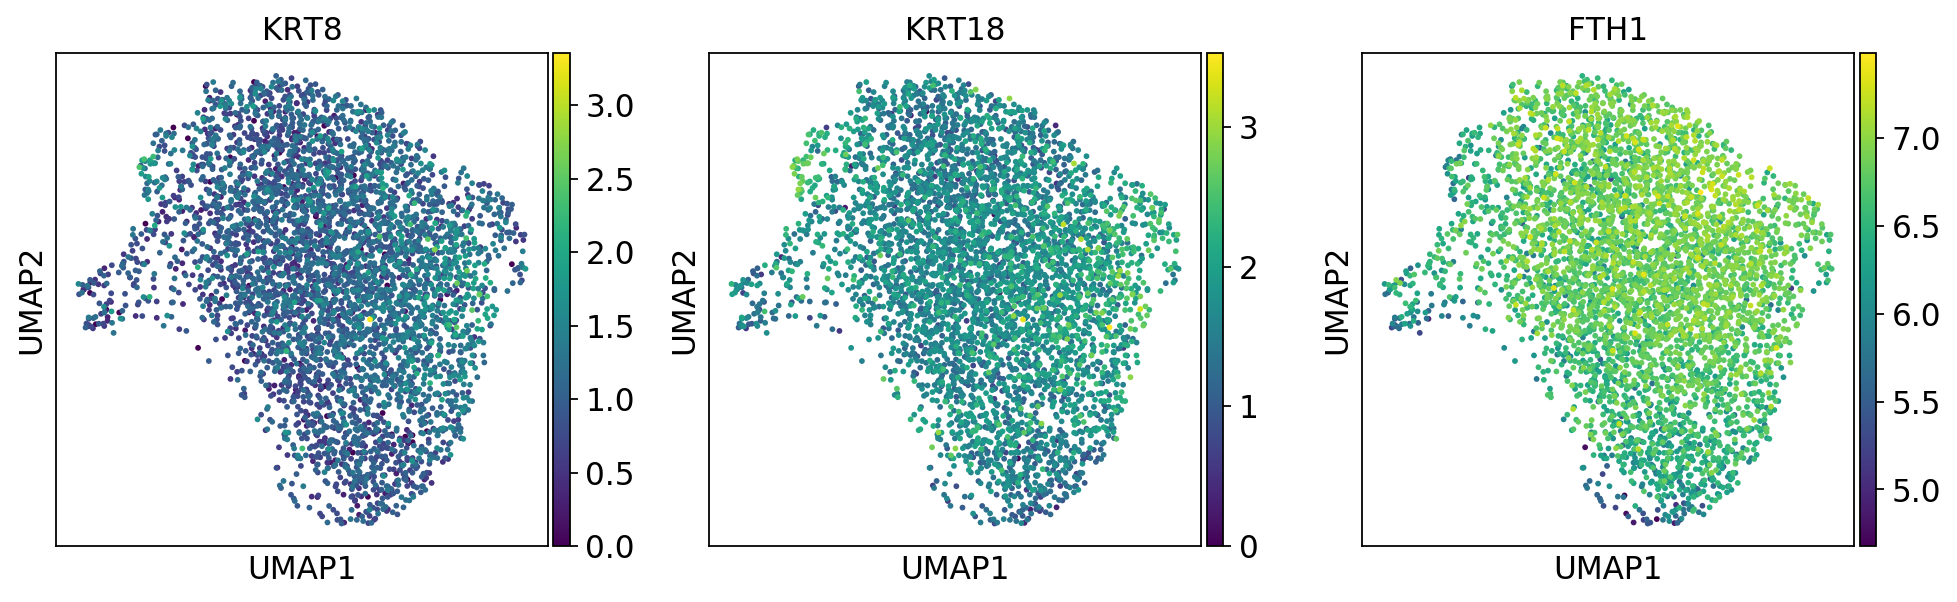

In [51]:
sc.pl.umap(ad_ctr, color=['KRT8', 'KRT18', 'FTH1'])
sc.pl.umap(ad_sin, color=['KRT8', 'KRT18', 'FTH1'])

# Cell Cycle check

In [ ]:
# Load cell cycle genes from Tirosh genes
